In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import compose

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn_evaluation import plot

In [2]:
data_df = pd.read_csv('heart.csv')
sex_oh_enc = pd.get_dummies(data_df["Sex"], dtype="int").rename(columns={"F":"Female", "M":"Male"})
chestPain_oh_enc = pd.get_dummies(data_df["ChestPainType"], dtype="int").rename(columns={"TA":"ChestPain_TA", "ATA":"ChestPain_ATA", "NAP":"ChestPain_NAP","ASY":"ChestPain_ASY"})
restECG_oh_enc = pd.get_dummies(data_df["RestingECG"], dtype="int").rename(columns={"Normal":"RestECG_Normal", "ST":"RestECG_ST", "LVH":"RestECG_LVH"})
st_slope_oh_enc = pd.get_dummies(data_df["ST_Slope"], dtype="int").rename(columns={"Up":"ST_Slope_Up", "Flat":"ST_Slope_Flat", "Down":"ST_Slope_Down"})
exerciseAngina_ord_enc = pd.DataFrame(pd.factorize(data_df["ExerciseAngina"])[0], columns=["ExerciseAngina"])

data_df_encoded = data_df.drop(columns=["Sex", "ChestPainType", "RestingECG", "ST_Slope", "ExerciseAngina"])
data_df_encoded = data_df_encoded.join([sex_oh_enc, chestPain_oh_enc, restECG_oh_enc, st_slope_oh_enc, exerciseAngina_ord_enc])
data_df_encoded = data_df_encoded[["Age",
                                  "Male", "Female",
                                  "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY",
                                  "RestingBP",
                                  "Cholesterol",
                                  "FastingBS",
                                  "RestECG_Normal", "RestECG_ST", "RestECG_LVH",
                                  "MaxHR",
                                  "ExerciseAngina",
                                  "Oldpeak",
                                  "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down",
                                  "HeartDisease"]]
categorical_columns = ["Male", "Female", "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY", "FastingBS", "RestECG_Normal", "RestECG_ST", "RestECG_LVH", "ExerciseAngina", "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down", "HeartDisease"]
for col in categorical_columns:
    data_df_encoded[col] = data_df_encoded[col].astype("category")
feature_names = data_df_encoded.columns
data_df_encoded

,Age,Male,Female,ChestPain_TA,ChestPain_ATA,ChestPain_NAP,ChestPain_ASY,RestingBP,Cholesterol,FastingBS,RestECG_Normal,RestECG_ST,RestECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,40,1,0,0,1,0,0,140,289,0,1,0,0,172,0,0.0,1,0,0,0
1,49,0,1,0,0,1,0,160,180,0,1,0,0,156,0,1.0,0,1,0,1
2,37,1,0,0,1,0,0,130,283,0,0,1,0,98,0,0.0,1,0,0,0
3,48,0,1,0,0,0,1,138,214,0,1,0,0,108,1,1.5,0,1,0,1
4,54,1,0,0,0,1,0,150,195,0,1,0,0,122,0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,0,1,0,0,0,110,264,0,1,0,0,132,0,1.2,0,1,0,1
914,68,1,0,0,0,0,1,144,193,1,1,0,0,141,0,3.4,0,1,0,1
915,57,1,0,0,0,0,1,130,131,0,1,0,0,115,1,1.2,0,1,0,1
916,57,0,1,0,1,0,0,130,236,0,0,0,1,174,0,0.0,0,1,0,1


In [3]:
X = np.array(data_df_encoded)[:,:-1]
y = np.array(data_df_encoded)[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=8)

In [4]:
# Normalize age, RestingBP, Cholesterol, MaxHR, and oldPeak

# Standardization (Z-score normzalization): zero-centered & unit variance
ct_std = compose.ColumnTransformer([("standard_scaler", preprocessing.StandardScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

# Min/Max Normalization (Linear Scaling): [0,1]
ct_mm = compose.ColumnTransformer([("min_max_scaler", preprocessing.MinMaxScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

X_train_std = ct_std.fit_transform(X_train)
X_test_std = ct_mm.fit_transform(X_test)
X_train_mm = ct_std.fit_transform(X_train)
X_test_mm = ct_mm.fit_transform(X_test)

In [5]:
# Transformations
X_train_us_polys = {}
X_test_us_polys = {}

X_train_std_polys = {}
X_test_std_polys = {}

X_train_mm_polys = {}
X_test_mm_polys = {}

model_degrees = range(1,3)

for degree in model_degrees:
    poly = preprocessing.PolynomialFeatures(degree)
    
    X_train_us_polys[degree] = poly.fit_transform(X_train)
    X_test_us_polys[degree] = poly.fit_transform(X_test)
    
    X_train_std_polys[degree] = poly.fit_transform(X_train_std)
    X_test_std_polys[degree] = poly.fit_transform(X_test_std)

    X_train_mm_polys[degree] = poly.fit_transform(X_train_mm)
    X_test_mm_polys[degree] = poly.fit_transform(X_test_mm)

unscaled, degree 1
Best:  {'neural_net__activation': 'logistic', 'neural_net__alpha': 0, 'neural_net__hidden_layer_sizes': 10}
	Training:
               precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       321
         1.0       0.79      0.79      0.79       413

    accuracy                           0.76       734
   macro avg       0.76      0.75      0.75       734
weighted avg       0.76      0.76      0.76       734

	Test:
               precision    recall  f1-score   support

         0.0       0.72      0.70      0.71        89
         1.0       0.72      0.75      0.74        95

    accuracy                           0.72       184
   macro avg       0.72      0.72      0.72       184
weighted avg       0.72      0.72      0.72       184



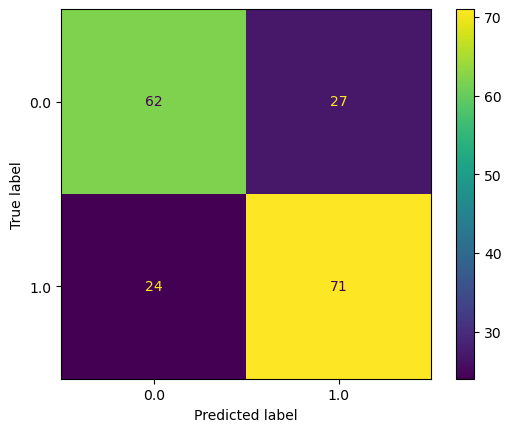

standardization, degree 1
Best:  {'neural_net__activation': 'relu', 'neural_net__alpha': 1, 'neural_net__hidden_layer_sizes': 10}
	Training:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       321
         1.0       0.88      0.92      0.90       413

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734

	Test:
               precision    recall  f1-score   support

         0.0       0.89      0.79      0.83        89
         1.0       0.82      0.91      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



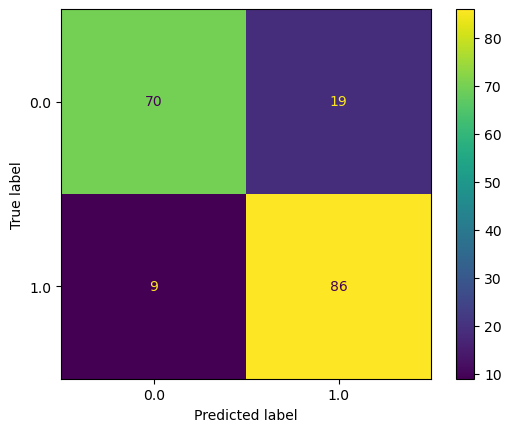

min-max scaled, degree 1
Best:  {'neural_net__activation': 'relu', 'neural_net__alpha': 1, 'neural_net__hidden_layer_sizes': 10}
	Training:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       321
         1.0       0.88      0.92      0.90       413

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734

	Test:
               precision    recall  f1-score   support

         0.0       0.89      0.79      0.83        89
         1.0       0.82      0.91      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



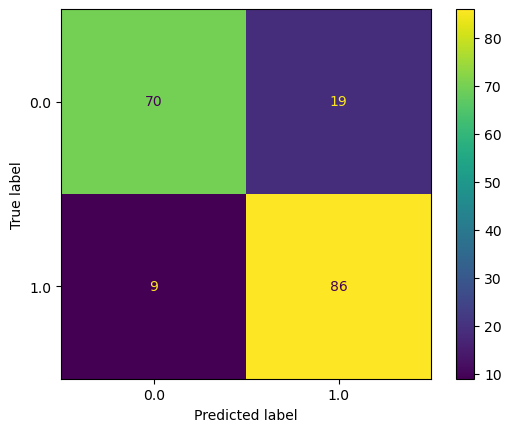

unscaled, degree 2
Best:  {'neural_net__activation': 'tanh', 'neural_net__alpha': 0.001, 'neural_net__hidden_layer_sizes': 15}
	Training:
               precision    recall  f1-score   support

         0.0       0.51      0.91      0.65       321
         1.0       0.82      0.32      0.46       413

    accuracy                           0.58       734
   macro avg       0.66      0.61      0.55       734
weighted avg       0.68      0.58      0.54       734

	Test:
               precision    recall  f1-score   support

         0.0       0.57      0.93      0.71        89
         1.0       0.85      0.35      0.49        95

    accuracy                           0.63       184
   macro avg       0.71      0.64      0.60       184
weighted avg       0.71      0.63      0.60       184



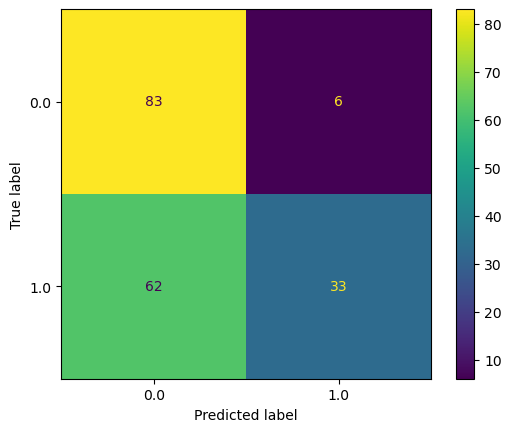

standardization, degree 2
Best:  {'neural_net__activation': 'relu', 'neural_net__alpha': 0, 'neural_net__hidden_layer_sizes': 10}
	Training:
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       321
         1.0       0.92      0.95      0.93       413

    accuracy                           0.93       734
   macro avg       0.93      0.92      0.92       734
weighted avg       0.93      0.93      0.92       734

	Test:
               precision    recall  f1-score   support

         0.0       0.85      0.78      0.81        89
         1.0       0.81      0.87      0.84        95

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



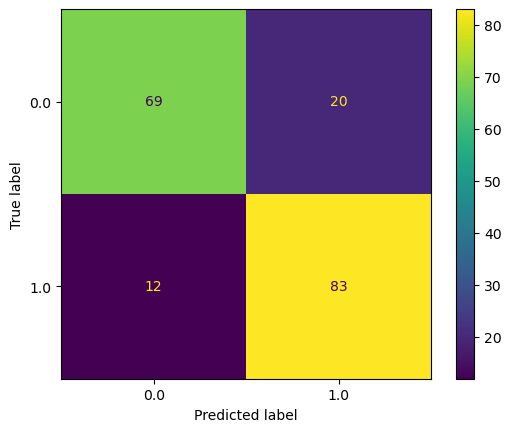

min-max scaled, degree 2
Best:  {'neural_net__activation': 'relu', 'neural_net__alpha': 0, 'neural_net__hidden_layer_sizes': 10}
	Training:
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       321
         1.0       0.92      0.95      0.93       413

    accuracy                           0.93       734
   macro avg       0.93      0.92      0.92       734
weighted avg       0.93      0.93      0.92       734

	Test:
               precision    recall  f1-score   support

         0.0       0.85      0.78      0.81        89
         1.0       0.81      0.87      0.84        95

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



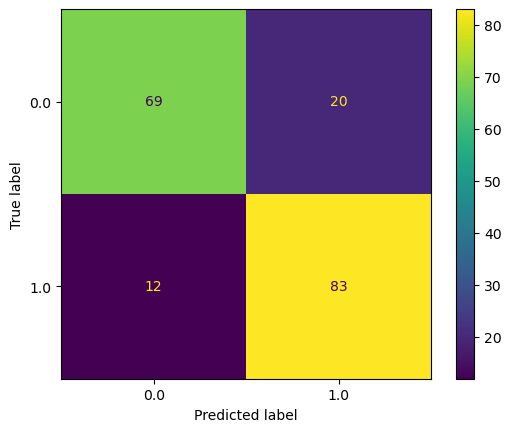

In [6]:
# Neural Network
pipe = Pipeline(steps=[('neural_net', MLPClassifier(solver='sgd', random_state=8, max_iter=10000))])
param_grid = {
    "neural_net__hidden_layer_sizes": [(10, 5), (15), (10), (5)],
    "neural_net__activation": ['logistic', 'tanh', 'relu'],
    "neural_net__alpha": [0, 0.001, 0.01, 0.1, 0.5, 1],
}
search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=4)

def show_nn_results(search, normalization, degree, X_train, X_test):
    # results_df = pd.DataFrame(search.cv_results_).get(["param_neural_net__activation", "param_neural_net__alpha", "param_neural_net__hidden_layer_sizes", "mean_test_score"])
    print(normalization + ", degree", degree)
    print("Best: ", search.best_params_) 
    print("\tTraining:\n", classification_report(y_train, search.best_estimator_.predict(X_train)))
    print("\tTest:\n", classification_report(y_test, search.best_estimator_.predict(X_test)))
    
    
    y_pred = search.best_estimator_.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    

pd.set_option('display.max_rows', 110)
for degree in model_degrees:
    search.fit(X_train_us_polys[degree], y_train)
    show_nn_results(search, "unscaled", degree, X_train_us_polys[degree], X_test_us_polys[degree])

    search.fit(X_train_std_polys[degree], y_train)
    show_nn_results(search, "standardization", degree, X_train_std_polys[degree], X_test_std_polys[degree])

    search.fit(X_train_mm_polys[degree], y_train)
    show_nn_results(search, "min-max scaled", degree, X_train_mm_polys[degree], X_test_mm_polys[degree])



Best performance from tests: ~85% from a neural network with one hidden layer made up of 10 neurons using ReLU as an activation function with L2 regularization ($\alpha=1$) on standardized or min-max scaled data.